In [1]:
%%script false --no-raise-error
%%bash
pip install numpy
pip install pandas
pip install matplotlib==3.7.0
pip install tikzplotlib
pip install scipy

In [2]:
import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

from scipy.optimize import curve_fit

from pathlib import Path

In [3]:
from packaging.version import Version
if Version(matplotlib.__version__) > Version('3.7.0'):
    raise RuntimeWarning('tikzplotlib cant work with matplotlib > 3.7')

import tikzplotlib
def tikzplotlib_fix_ncols(obj):
    """
    workaround for matplotlib 3.6 renamed legend's _ncol to _ncols, which breaks tikzplotlib
    """
    if hasattr(obj, "_ncols"):
        obj._ncol = obj._ncols
    for child in obj.get_children():
        tikzplotlib_fix_ncols(child)

In [4]:
ROOT_PATH = Path('./..')

LATEX_PATH = ROOT_PATH / 'paper'

RESOURCES_PATH = ROOT_PATH / 'resources'

CPP_BUILD_PATH = ROOT_PATH / 'build'

# Расходно напорная характеристика

In [5]:
# initials
P = np.array([2808.80274448953, 2964.84734140562, 2902.42950263918, 2715.17598633988, 2496.71355065736, 2325.06449404967, 2059.78867929232, 1279.5656947119, 592.969468281124])
Q = np.array([0, 5.58329944639905, 11.1665988927981, 16.7498983391972, 22.3331977855962, 25.1248475087957, 27.9164972319952, 33.4997966783943, 37.9664362355135])

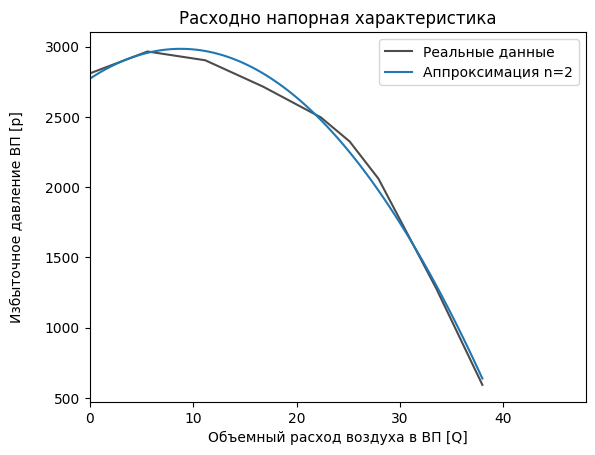

In [6]:
%matplotlib inline
fig, ax = plt.subplots()

ax.plot(Q, P, 'k', label='Реальные данные', alpha=0.7)

_z = np.polyfit(Q, P, 2)
_p = np.poly1d(_z)
_dp = _p.deriv()
_xp = np.linspace(Q.min(), Q.max(), 100)
ax.plot(_xp, _p(_xp), label=f'Аппроксимация n={2}')

ax.set_xlabel('Объемный расход воздуха в ВП [Q]')
ax.set_ylabel('Избыточное давление ВП [p]', labelpad=15)
ax.set_xlim(Q.min(), Q.max() + 10)
plt.title('Расходно напорная характеристика')
plt.legend()
plt.plot();

# tikzplotlib_fix_ncols(fig)
# tikzplotlib.save(LATEX_PATH / 'graph_tikz.tex')


In [7]:
print('Квадратичная функция: ', _p, sep='\n')
A, B, C = _p.coefficients
q_max = 8.791162734091653
print('Вершина параболы:', -B / 2 / A)
print('Максимальное давление:', _p(q_max))

Квадратичная функция: 
        2
-2.756 x + 48.46 x + 2771
Вершина параболы: 8.791162734091653
Максимальное давление: 2983.8648146802116


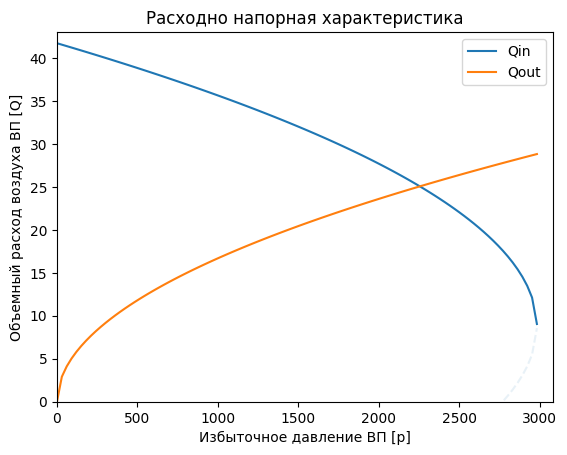

In [8]:
def Qin(p: float, right=True) -> float:
    A = -2.756
    B = 48.46
    C = 2771

    D = B * B - 4 * A * (C - p)
    if right:
        return (-B - np.sqrt(D)) / 2 / A
    return (-B + np.sqrt(D)) / 2 / A


def Qout(p: float) -> float:
    Sgap = 0.42
    rho = 1.269
    chi = 1
    return chi * np.sqrt(2 * p / rho) * Sgap


def maxP() -> float:
    Qtop = -B / 2 / A
    lo = 0.0
    hi = A * Qtop * Qtop + B * Qtop + C
    return hi


fig, ax = plt.subplots()
_xp = np.linspace(0, maxP(), 100, endpoint=True)
ax.plot(_xp, Qin(_xp), label='Qin')
ax.plot(_xp, Qin(_xp, right=False), 'C0--', alpha=0.1)
ax.plot(_xp, Qout(_xp), label='Qout')
# ax.plot(_xp, Qin(_xp) - Qout(_xp), label='Qin - Qout')
ax.set_xlim(0, maxP() + 100)
ax.set_ylim(0, 43)
ax.set_ylabel('Объемный расход воздуха ВП [Q]')
ax.set_xlabel('Избыточное давление ВП [p]')
plt.title('Расходно напорная характеристика')
plt.legend()
plt.plot();

# tikzplotlib_fix_ncols(fig)
# tikzplotlib.save(LATEX_PATH / 'graph2_tikz.tex')

## Коэффициент демпфирования

In [9]:
# initials
D = np.array([2483720.930232558, 2218604.6511627906, 2002325.5813953488, 1756395.3488372092, 1533139.5348837208, 1311627.906976744, 1065697.6744186047, 868604.6511627907, 488372.0930232558, 279069.76744186046, 174418.60465116278, 129069.76744186046, 94186.04651162791, 75000, 61046.51162790698, 43604.651162790695, 33139.53488372093, 31395.3488372093, 26162.79069767442, 24418.60465116279, 15697.67441860465, 8720.93023255814, 8720.93023255814, 6976.7441860465115])
S_gap_S = np.array([0.0009855072463768116, 0.0011207729468599033, 0.0012463768115942029, 0.001391304347826087, 0.0015169082125603866, 0.001681159420289855, 0.0018743961352657005, 0.002038647342995169, 0.0024057971014492755, 0.0030144927536231883, 0.004048309178743961, 0.004801932367149759, 0.005603864734299517, 0.006338164251207729, 0.007246376811594203, 0.008367149758454106, 0.009536231884057972, 0.010743961352657004, 0.01182608695652174, 0.012937198067632851, 0.014309178743961353, 0.01592270531400966, 0.017072463768115942, 0.018309178743961353])

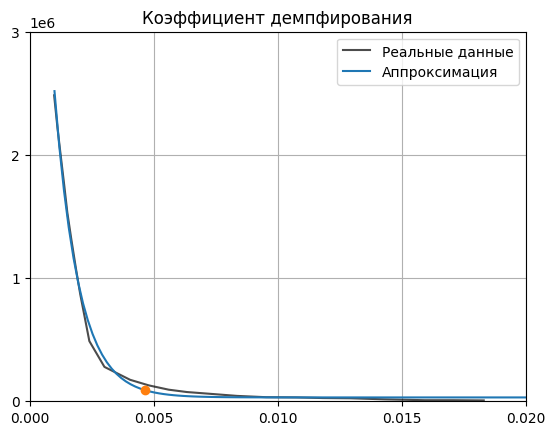

In [10]:
def f(x, a, b, c):
    return a + b * np.exp(-c * x)


fig, ax = plt.subplots()
ax.plot(S_gap_S, D, 'k', label='Реальные данные', alpha=0.7)

popt, _ = curve_fit(f, S_gap_S, D, bounds=(0, np.inf), method='trf')
_xp = np.linspace(0.001, 0.02, 100, endpoint=True)
ax.plot(_xp, f(_xp, *popt), label=f'Аппроксимация')

ax.plot(0.004667, f(0.004667, *popt), 'o')

ax.set_xlim(0, 0.02)
ax.set_xticks([0, 0.005, 0.01, 0.015, 0.02])
ax.set_ylim(0, 3e6)
ax.set_yticks([0, 1e6, 2e6, 3e6])
plt.title('Коэффициент демпфирования')
plt.legend()
plt.legend(loc='best')
plt.grid(True)
plt.plot();

In [11]:
print('Экспоненциальная функция:')
print(f'{popt[0]} + {popt[1]} * np.exp({popt[2]} * x)')

Экспоненциальная функция:
31253.553067256977 + 6930673.352075487 * np.exp(1025.1778568097657 * x)


## Визуализация состояний системы

In [14]:
SIMULATION_DT = 1e-6 * 10000

df = pd.read_csv(RESOURCES_PATH / 'sim_23.csv', delimiter='\t')
df['dt'] = df.index * SIMULATION_DT
df.head(10)

,H,dV_y/dt,phi,p,Q_in,Q_out,dt
0,0.696828,0.865417,0.0,50.31810,41.4181,41.4193,0.00
1,0.702622,0.035924,0.0,20.60530,41.5829,41.4563,0.01
2,0.708995,-0.863894,0.0,5.87685,41.6643,41.6612,0.02
3,0.701436,-0.072656,0.0,18.09180,41.5968,41.7036,0.03
4,0.692705,0.860807,0.0,51.38890,41.4121,41.4120,0.04
5,0.697857,0.109322,0.0,23.50990,41.5668,41.4178,0.05
6,0.704772,-0.856157,0.0,6.05429,41.6633,41.6565,0.06
7,0.697879,-0.145681,0.0,16.82410,41.6038,41.6955,0.07
8,0.688636,0.849965,0.0,52.48890,41.4060,41.4110,0.08
9,0.693100,0.181933,0.0,27.03480,41.5473,41.3708,0.09


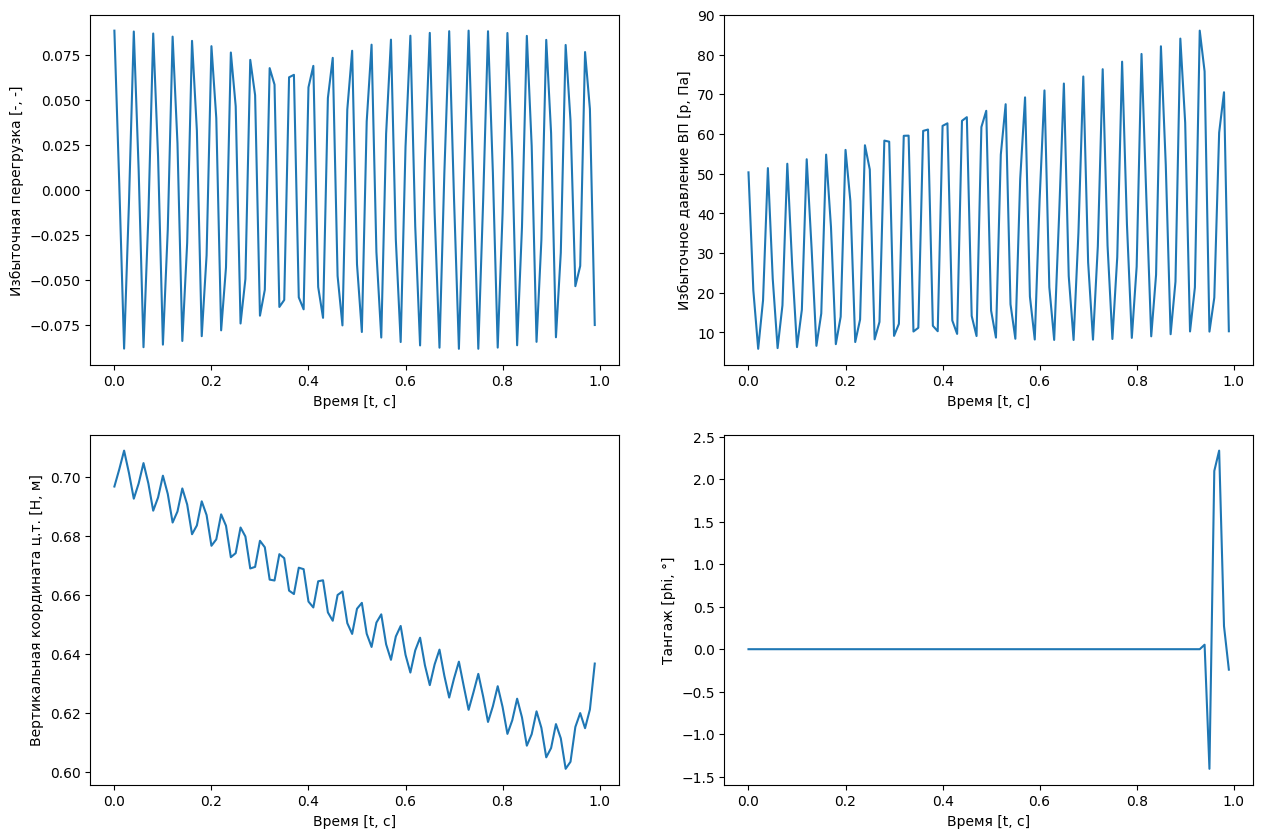

In [15]:
tb = df

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

ax1.plot(tb['dt'], tb['dV_y/dt'] / 9.8)
ax1.set_ylabel('Избыточная перегрузка [-, -]')
ax1.set_xlabel('Время [t, с]')

ax2.plot(tb['dt'], tb['p'])
ax2.set_ylabel('Избыточное давление ВП [p, Па]')
ax2.set_xlabel('Время [t, с]')

ax3.plot(tb['dt'], tb['H'])
ax3.set_ylabel('Вертикальная координата ц.т. [H, м]')
ax3.set_xlabel('Время [t, с]')

ax4.plot(tb['dt'], list(map(math.degrees, tb['phi'])))
ax4.set_ylabel('Тангаж [phi, °]')
ax4.set_xlabel('Время [t, с]')

plt.plot();